In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Create time series dataset of length 128 with 3 classes
# training dataset
idx=np.arange(0,128)
train_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(5000,128)
train_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(5000,128)
train_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(5000,128)
x_train=np.concatenate([train_data_class1,train_data_class2,train_data_class3],0)

# test dataset
test_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(1000,128)
test_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(1000,128)
test_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(1000,128)
x_test=np.concatenate([test_data_class1,test_data_class2,test_data_class3],0)

# create labels for training and test data
y_train=np.concatenate([np.zeros(5000),np.ones(5000),np.ones(5000)*2],0)
y_test=np.concatenate([np.zeros(1000),np.ones(1000),np.ones(1000)*2],0)

y_train.astype(int)
y_test.astype(int)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
y_train=tf.cast(y_train,tf.uint8)
y_test=tf.cast(y_test,tf.uint8)

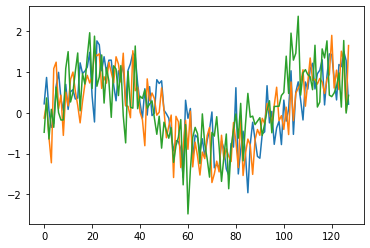

In [15]:
# plot time series data
# class 1
plt.plot(x_train[1])
# class 1
plt.plot(x_train[5000+1])
# class 1
plt.plot(x_train[10000+1])

In [16]:
# time series dataset parameters.
num_classes = 3 # total classes 3

# Training parameters.
learning_rate = 0.001
training_steps = 500
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 256 # number of neurons for 1st fully-connected layer.

In [17]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [18]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, 1, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, 1, k, 1], strides=[1, 1, k, 1], padding='SAME')

In [19]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 1x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([1, 5, 1, conv1_filters])),
    # Conv Layer 2: 1x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([1, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 1*32*64 inputs, 256 units.
    'wd1': tf.Variable(random_normal([1*32*64, fc1_units])),
    # FC Out Layer: 256 inputs, 3 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [20]:
# Create model
def conv_net(x):
    
    # Input shape: [-1, 1, 128, 1]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 1, 128, 1])

    # Convolution Layer. Output shape: [-1, 1, 128, 32].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 1, 64, 32].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 1, 64, 64].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 1, 32, 64].
    conv2 = maxpool2d(conv2, k=2)

    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 1*32*64].
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 256].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Fully connected layer, Output shape: [-1, 3].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [21]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [22]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [23]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 94.288239, accuracy: 0.750000
step: 20, loss: 89.921356, accuracy: 0.875000
step: 30, loss: 82.404716, accuracy: 0.945312
step: 40, loss: 94.140244, accuracy: 0.742188
step: 50, loss: 140.079803, accuracy: 0.703125
step: 60, loss: 136.476532, accuracy: 0.500000
step: 70, loss: 121.292938, accuracy: 0.679688
step: 80, loss: 84.550186, accuracy: 0.687500
step: 90, loss: 36.010185, accuracy: 0.890625
step: 100, loss: 23.663563, accuracy: 0.953125
step: 110, loss: 8.481789, accuracy: 0.968750
step: 120, loss: 18.834997, accuracy: 0.953125
step: 130, loss: 19.945648, accuracy: 0.921875
step: 140, loss: 23.052046, accuracy: 0.921875
step: 150, loss: 17.600929, accuracy: 0.945312
step: 160, loss: 21.404789, accuracy: 0.953125
step: 170, loss: 13.932512, accuracy: 0.953125
step: 180, loss: 15.794260, accuracy: 0.960938
step: 190, loss: 17.626011, accuracy: 0.945312
step: 200, loss: 13.074142, accuracy: 0.968750
step: 210, loss: 6.605041, accuracy: 0.992188
step: 220, loss: 7.60

In [24]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.954000
